In [2]:
%load_ext pycodestyle_magic
%pycodestyle_on

# Follows pep8 style guidelines

In [3]:
import numpy as np
import math as m
from matplotlib import pyplot as plt

from scipy import integrate
from scipy.signal import argrelextrema, argrelmin, find_peaks
from scipy.integrate import solve_ivp

# Project Background

This project aims to computationally solve a set of differential equations in order to characterize a simplified model of tropospheric chemistry.   <br> 
While the atmosphere is made up of many complex chemical and thermodynamic systems, we are solely focusing on the chemical reactions in this model.  <br> 
Looking at the chemical reactions helps us to understand the “underlying dynamic structure” and conditions for the chemical system in the atmosphere.  <br> 
In following the Field et. al paper “Characterization of oscillation and a period-doubling transition to chaos reflecting dynamic instability in a simplified model of tropospheric chemistry” and Professor Sarah Kavassalis’ paper “Consequences of nonlinear dynamics in tropospheric photochemistry”, we observe different characteristics of the model based including unstable steady states, oscillations, and deterministic chaos.  <br> 
In characterizing this simplified model, we aim to learn about chemical interactions that predict the composition of our tropospheric system (Field 7554).  <br> 

In [4]:
# This cell made by Prof Sarah Kavassalis

# Definition of rate constants
k4 = 6.9E-8
k5 = 1.9E-13
k6 = 1.5E-15
k7 = 7.9E-15
k8 = 3.9E-3
k9 = 9.6E-12
k10 = 1.3E-11

# emissions/static sources (forcings)
# these can be altered to show different dynamics
FCO = 5E5
FNO = 6.3E4
FO3 = 6E4


def dXdt(t, X):
    """ Returns differential equations for different compounds

        Args:
            t: float, time
            X: list, initial conditions
    """
    CO, NO, O3, NO2, OH, HO2 = X

    dCOdt = + FCO - k5*CO*OH
    dNOdt = + FNO + k8*NO2 - k7*NO*O3 - k9*HO2*NO
    dO3dt = + FO3 + k8*NO2 - k4*O3-k6*HO2*O3 - k7*NO*O3
    dNO2dt = + k7*NO*O3+k9*HO2*NO - k8*NO2 - k10*OH*NO2
    dOHdt = + 2*k4*O3 + k6*HO2*O3 + k9*HO2*NO - k5*OH*CO - k10*OH*NO2
    dHO2dt = + k5*OH*CO - k6*HO2*O3 - k9*HO2*NO

    return dCOdt, dNOdt, dO3dt, dNO2dt, dOHdt, dHO2dt


# defining integration time, arbitrarily chosen
t0, tf = 0, 10E7

# initial conditions
X0 = 5E11, 5E9, 3E11, 5E9, 5E6, 2.5E8

# differentiation formula (LSODA) chosen because these systems are very stiff
X = solve_ivp(dXdt, (t0, tf), X0, method='LSODA')
X.t = X.t/(24*60*60)  # converting time to days

CO, NO, O3, NO2, OH, HO2 = X.y  # renaming based on concentrations

# Helper Functions for Plotting

In [5]:
# Plotting helper function

def plots(subplot, row, col, x, y, xlabel, ylabel, xpeaks=[],
          ypeaks=[], title="default"):
    """Creates a phase plot, time plot, or time plot with peaks highlighted

    Args:
        subplot: subplot name
        row: int, subplot row (if 1D, this could be -1)
        col: int, subplot col (if 1D, this could be -1)
        x: an array of data for x-axis
        y: an array of data for y-axis
        xlabel: string describing x data
        ylabel: string describing y data
        peaksx: array of peaks if plotting
        peaksy: array of peaks if plotting
        title (optional): string with title, else defaults to phase plot title
    """

    # Fixing x and y labels
    if (xlabel == 'time'):
        xtitle = 'time (days) ' + 'molec/$cm^3$'
        ytitle = '[' + ylabel + '] ' + 'molec/$cm^3$'
    else:  # type will be phase
        xtitle = '[' + xlabel + '] ' + 'molec/$cm^3$'
        ytitle = '[' + ylabel + '] ' + 'molec/$cm^3$'

    # default title for phase plots
    if (title == "default"):
        title = '[' + xlabel + ']' + ' vs [' + ylabel + '] ' + 'molec/$cm^3$'

    # Plotting
    if ((row == -1) or (col == -1)):  # Plotting for 1D
        idx = max(row, col)
        if (idx == -1):
            raise TypeError("axs inputs invalid")

        # Checking for peaks
        if (len(xpeaks) != 0):
            subplot[idx].scatter(xpeaks, ypeaks, linewidth=7)

        subplot[idx].plot(x, y, '#d95f02', linewidth=5)
        subplot[idx].grid()
        subplot[idx].set_xlabel(xtitle, fontsize=30)
        subplot[idx].set_ylabel(ytitle, fontsize=30)
        subplot[idx].set_title(title, fontsize=35)

    else:  # Plotting for not 1D
        # Checking for peaks
        if (len(xpeaks) != 0):
            subplot[row, col].scatter(xpeaks, ypeaks, linewidth=7)

        # Plotting
        subplot[row, col].plot(x, y, '#d95f02', linewidth=3)
        subplot[row, col].grid()
        subplot[row, col].set_xlabel(xtitle, fontsize=30)
        subplot[row, col].set_ylabel(ytitle, fontsize=30)
        subplot[row, col].set_title(title, fontsize=35)

In [6]:
def find_CO_OH_time():
    """Calculates the CO and OH values over time.

    Returns:
        array: CO values over time.
        array: OH values over time.
    """
    X = solve_ivp(dXdt, (t0, tf), X0, t_eval=t, method='LSODA')
    X.t = X.t/(24*60*60)
    CO, NO, O3, NO2, OH, HO2 = X.y
    return CO, OH, X.t

# Phase Diagrams

If we make plots between any of the six involved variables (CO, O3, NO, NO2, HO, HO2), we will find a period attractor cycle. <br> 
    
In the following section, we first look at 2-D spaces that are part of the six-dimensional phase space between the previously mentioned molecules.  <br> 
In the Field et. al paper, they specifically look at the cycle between [HO] and [CO].  <br> 
This is because [CO] is the oxidant that starts the chain reaction creating ozone while [HO] gets oxidized and is central to the oxidation of pollutants.  <br> 
So, take special note of the first plot in the following cell. <br> 
    
Also, when solving differential equations, our systems have a certain amount of “spin up”, which is chaotic behavior that occurs right before a system settles down.  <br> 
“Spin up” often occurs because of a certain set of initial conditions. So, while creating phase diagrams, I skipped more than half of the timesteps before plotting phase space. <br> 

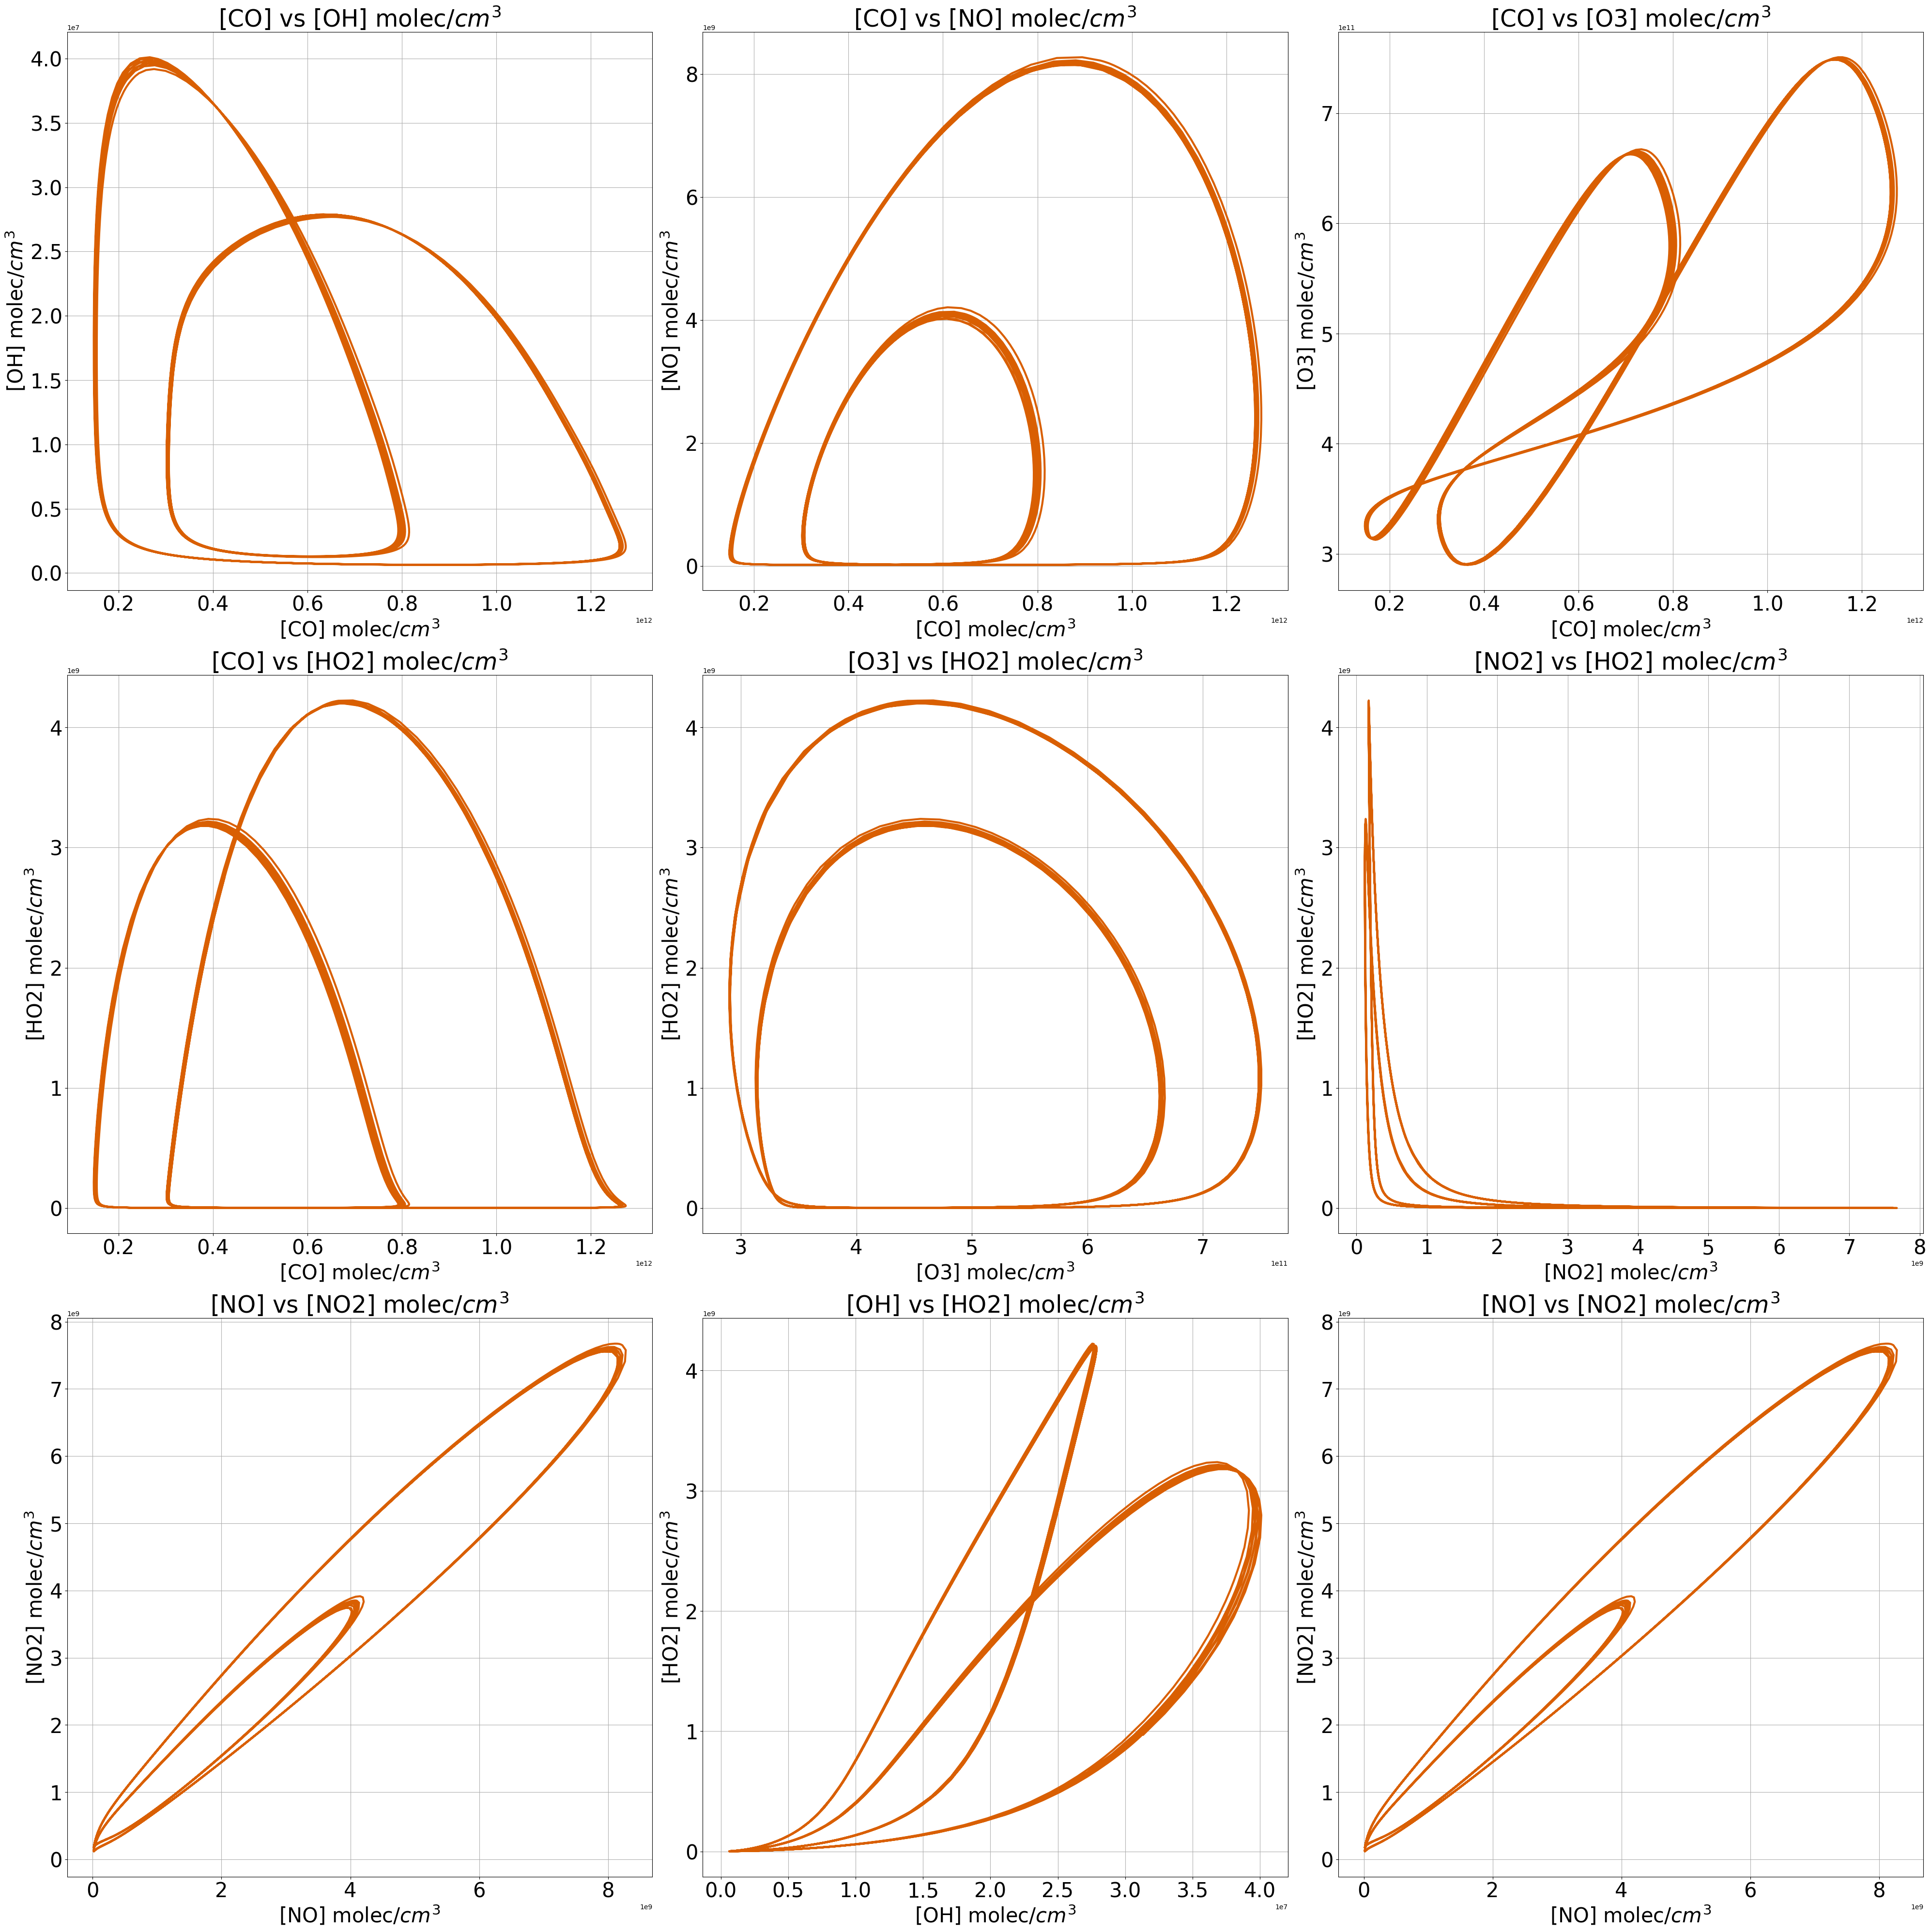

In [7]:
# The following cell is adapted from code written by Prof. Kavassalis

# find first index after spin up
spin_up = .5  # arbitrary value based on experimentation
beg_idx = round(len(CO)*spin_up)

# Plotting set up
subplot_rows = 3
subplot_cols = 3
fig, axs = plt.subplots(subplot_rows, subplot_cols, figsize=(40, 40))

# Making several different phase plots
plots(axs, 0, 0, CO[beg_idx:], OH[beg_idx:], 'CO', 'OH')
plots(axs, 0, 1, CO[beg_idx:], NO[beg_idx:], 'CO', 'NO')
plots(axs, 0, 2, CO[beg_idx:], O3[beg_idx:], 'CO', 'O3')
plots(axs, 1, 0, CO[beg_idx:], HO2[beg_idx:], 'CO', 'HO2')
plots(axs, 1, 1, O3[beg_idx:], HO2[beg_idx:], 'O3', 'HO2')
plots(axs, 1, 2, NO2[beg_idx:], HO2[beg_idx:], 'NO2', 'HO2')
plots(axs, 2, 0, NO[beg_idx:], NO2[beg_idx:], 'NO', 'NO2')
plots(axs, 2, 1, OH[beg_idx:], HO2[beg_idx:], 'OH', 'HO2')
plots(axs, 2, 2, NO[beg_idx:], NO2[beg_idx:], 'NO', 'NO2')


for ax in axs.flat:
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
plt.show()

# Phase Diagrams Over Time
In this second set of phase plots, we look at different segments of a single time period between [OH] and [CO].  <br> 
We can notice how the phase cycle builds on itself over time, and this periodic limit cycle remains within the selected time period (~ 3 years). 


Text(0.5, 1.0, '[CO] vs. [OH] Phase (~370days-3620days)')

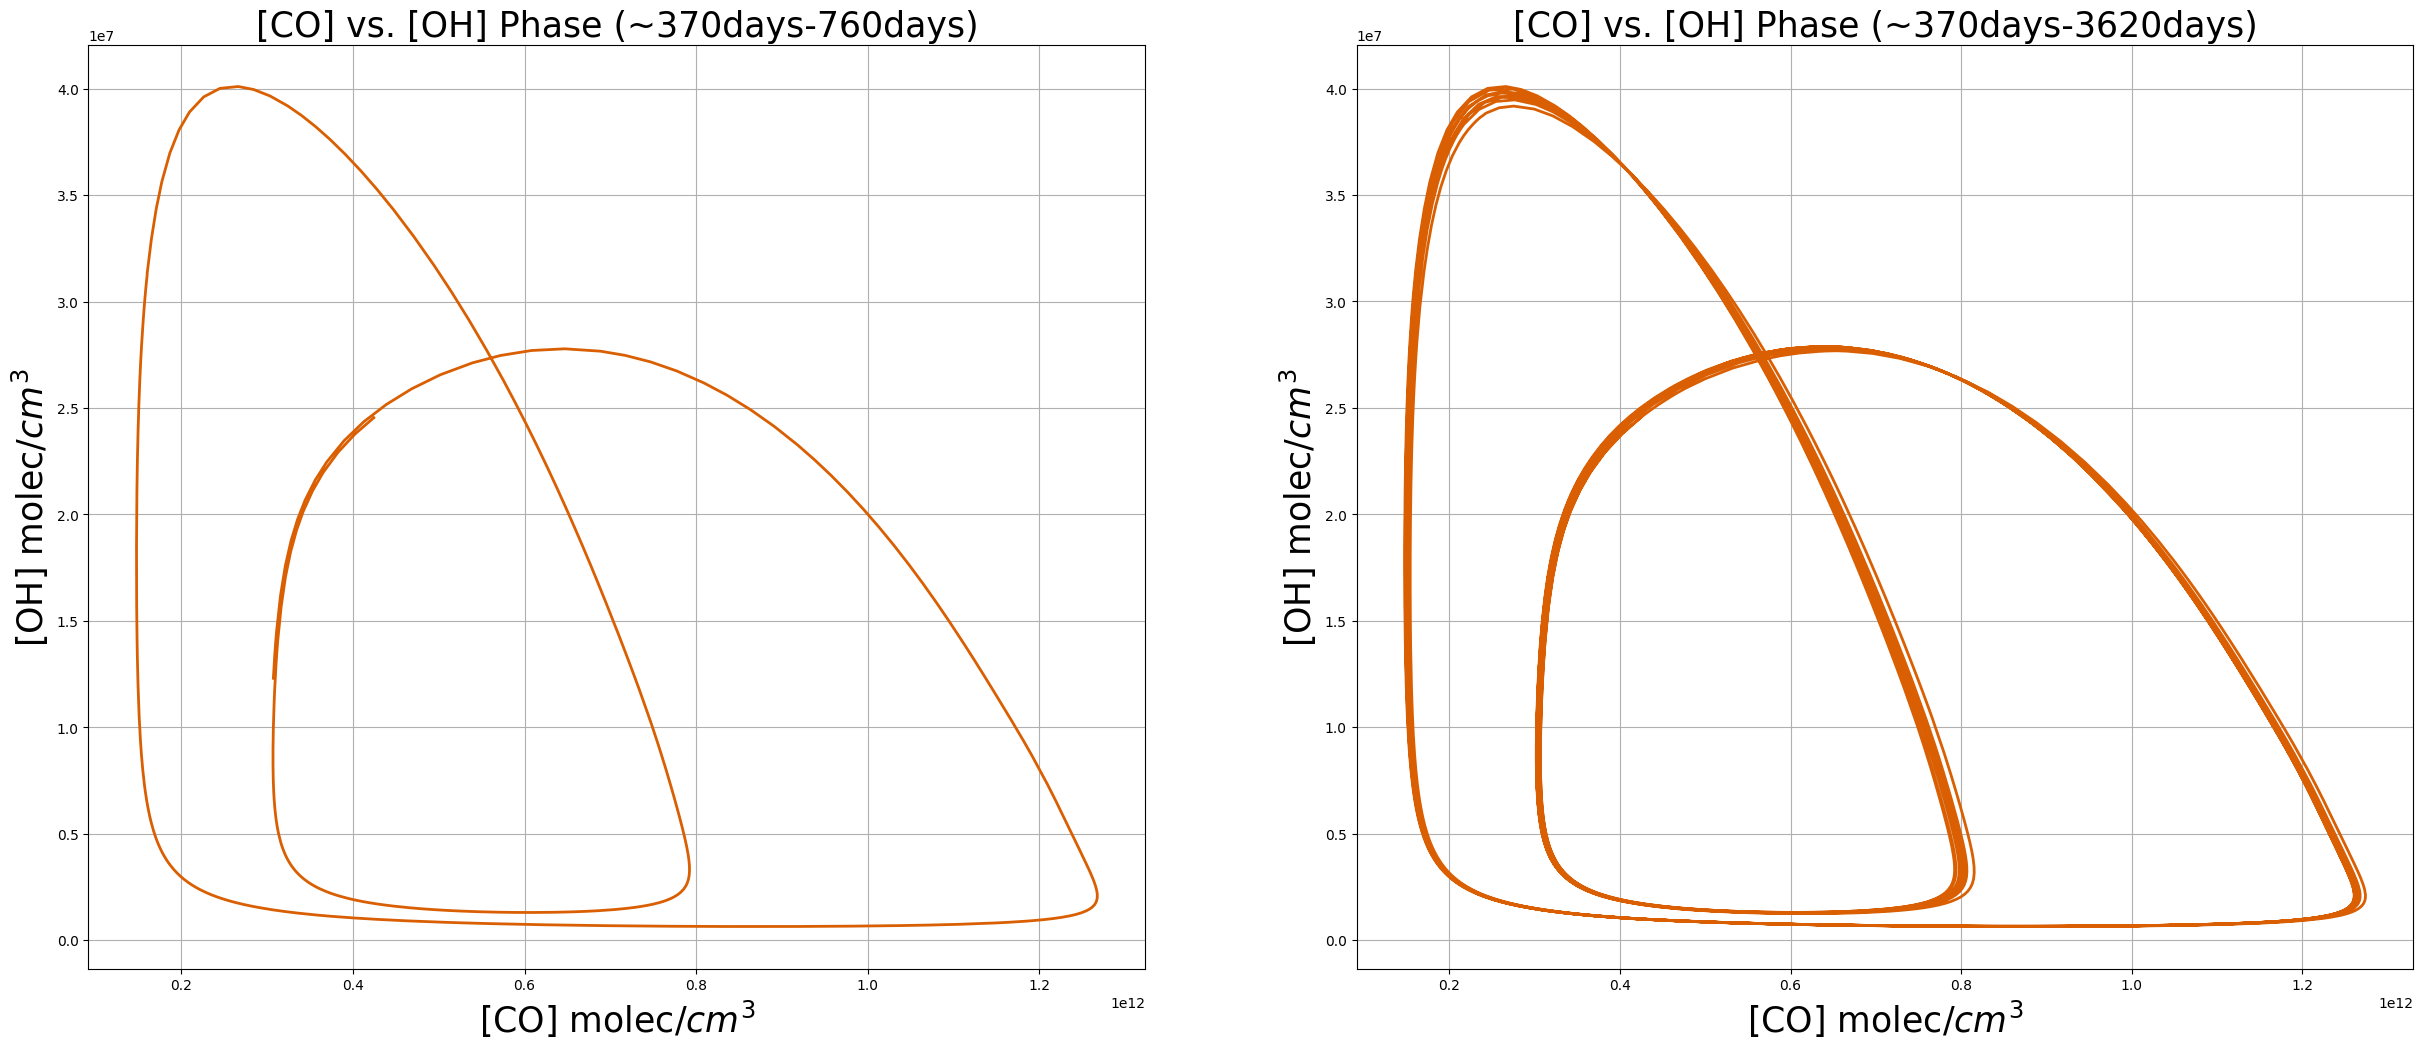

In [8]:
# Plotting with one FNO value showing different segments of one time period

# FNO value from Field et. al paper (for a period of 2)
FNO = 6.3E4
fig, axs = plt.subplots(1, 2, figsize=(30, 12))

# Setup time for integration
time_steps = 10000  # arbitrarily chosen
t = np.linspace(t0, tf, time_steps)

# Integration
X = solve_ivp(dXdt, (t0, tf), X0, method='LSODA')
X.t = X.t/(24*60*60)  # time to days
CO, NO, O3, NO2, OH, HO2 = X.y

# find where actual data starts after spin up
spin_up = .5
beg_idx = round(len(CO)*spin_up)
percent = round(len(CO)/100)

# one cycle , ~ 370 days to 760 days
single_cycle = 6*percent  # value found by experimentation
axs[0].plot(CO[beg_idx:beg_idx+(single_cycle)],
            OH[beg_idx:beg_idx+(single_cycle)], '#d95f02', linewidth=2)
axs[0].grid()
axs[0].set_xlabel('[CO] molec/$cm^3$', fontsize=25)
axs[0].set_ylabel('[OH] molec/$cm^3$', fontsize=25)
axs[0].set_title('[CO] vs. [OH] Phase (~370days-760days)', fontsize=25)

# multiple cycles
axs[1].plot(CO[beg_idx:], OH[beg_idx:], '#d95f02', linewidth=2)
axs[1].grid()
axs[1].set_xlabel('[CO] molec/$cm^3$', fontsize=25)
axs[1].set_ylabel('[OH] molec/$cm^3$', fontsize=25)
axs[1].set_title('[CO] vs. [OH] Phase (~370days-3620days)', fontsize=25)

# Period Doubling

This next set of phase-space plots looks at period doubling.  <br> 
In period doubling, changing a parameter creates a new periodic oscillation. <br> 
The period of this new oscillation will have a period that is double of the original period, hence “period doubling”.  <br> 
In phase diagrams, we can track period doubling by observing how phase also doubles as the period doubles. <br>  <br> 

In the Field et. al paper, they specifically look at the cycle between [OH] and [CO].  <br> 
This is because [CO] is the oxidant that starts the chain reaction creating ozone while [OH] gets oxidized and is central to the oxidation of pollutants.  <br>  <br> 

This section will include the following subsections: 
1. Calculations
2. Period Doubling + Phase Diagrams
3. Period Doubling + Time 
4. Period Finding

**1. Calculations**

We will use varying FNO values from the Field et. al paper to visualize the period doubling effect. 
We will observe the phase and time plots for period 1, period 2, period 4, and chaotic relationships.

In [9]:
# Phase-space for period doubling calculations

# integration time setup
time_steps = 10000
t = np.linspace(t0, tf, time_steps)
spin_up = .5  # Chosen arbitrarily
beg_idx = round(time_steps * spin_up)

# Period 1 Calculations
FNO = 5.3E4
period1_CO, period1_OH, period1_time = find_CO_OH_time()

# Period 2 Calculations
FNO = 6.1E4
period2_CO, period2_OH, period2_time = find_CO_OH_time()

# Period 4 Calculations
FNO = 7.2E4
period4_CO, period4_OH, period4_time = find_CO_OH_time()

# Chaos Calculations
FNO = 7.5E4
chaos_CO, chaos_OH, __ = find_CO_OH_time()

**2. Period Doubling + Phase Diagrams**

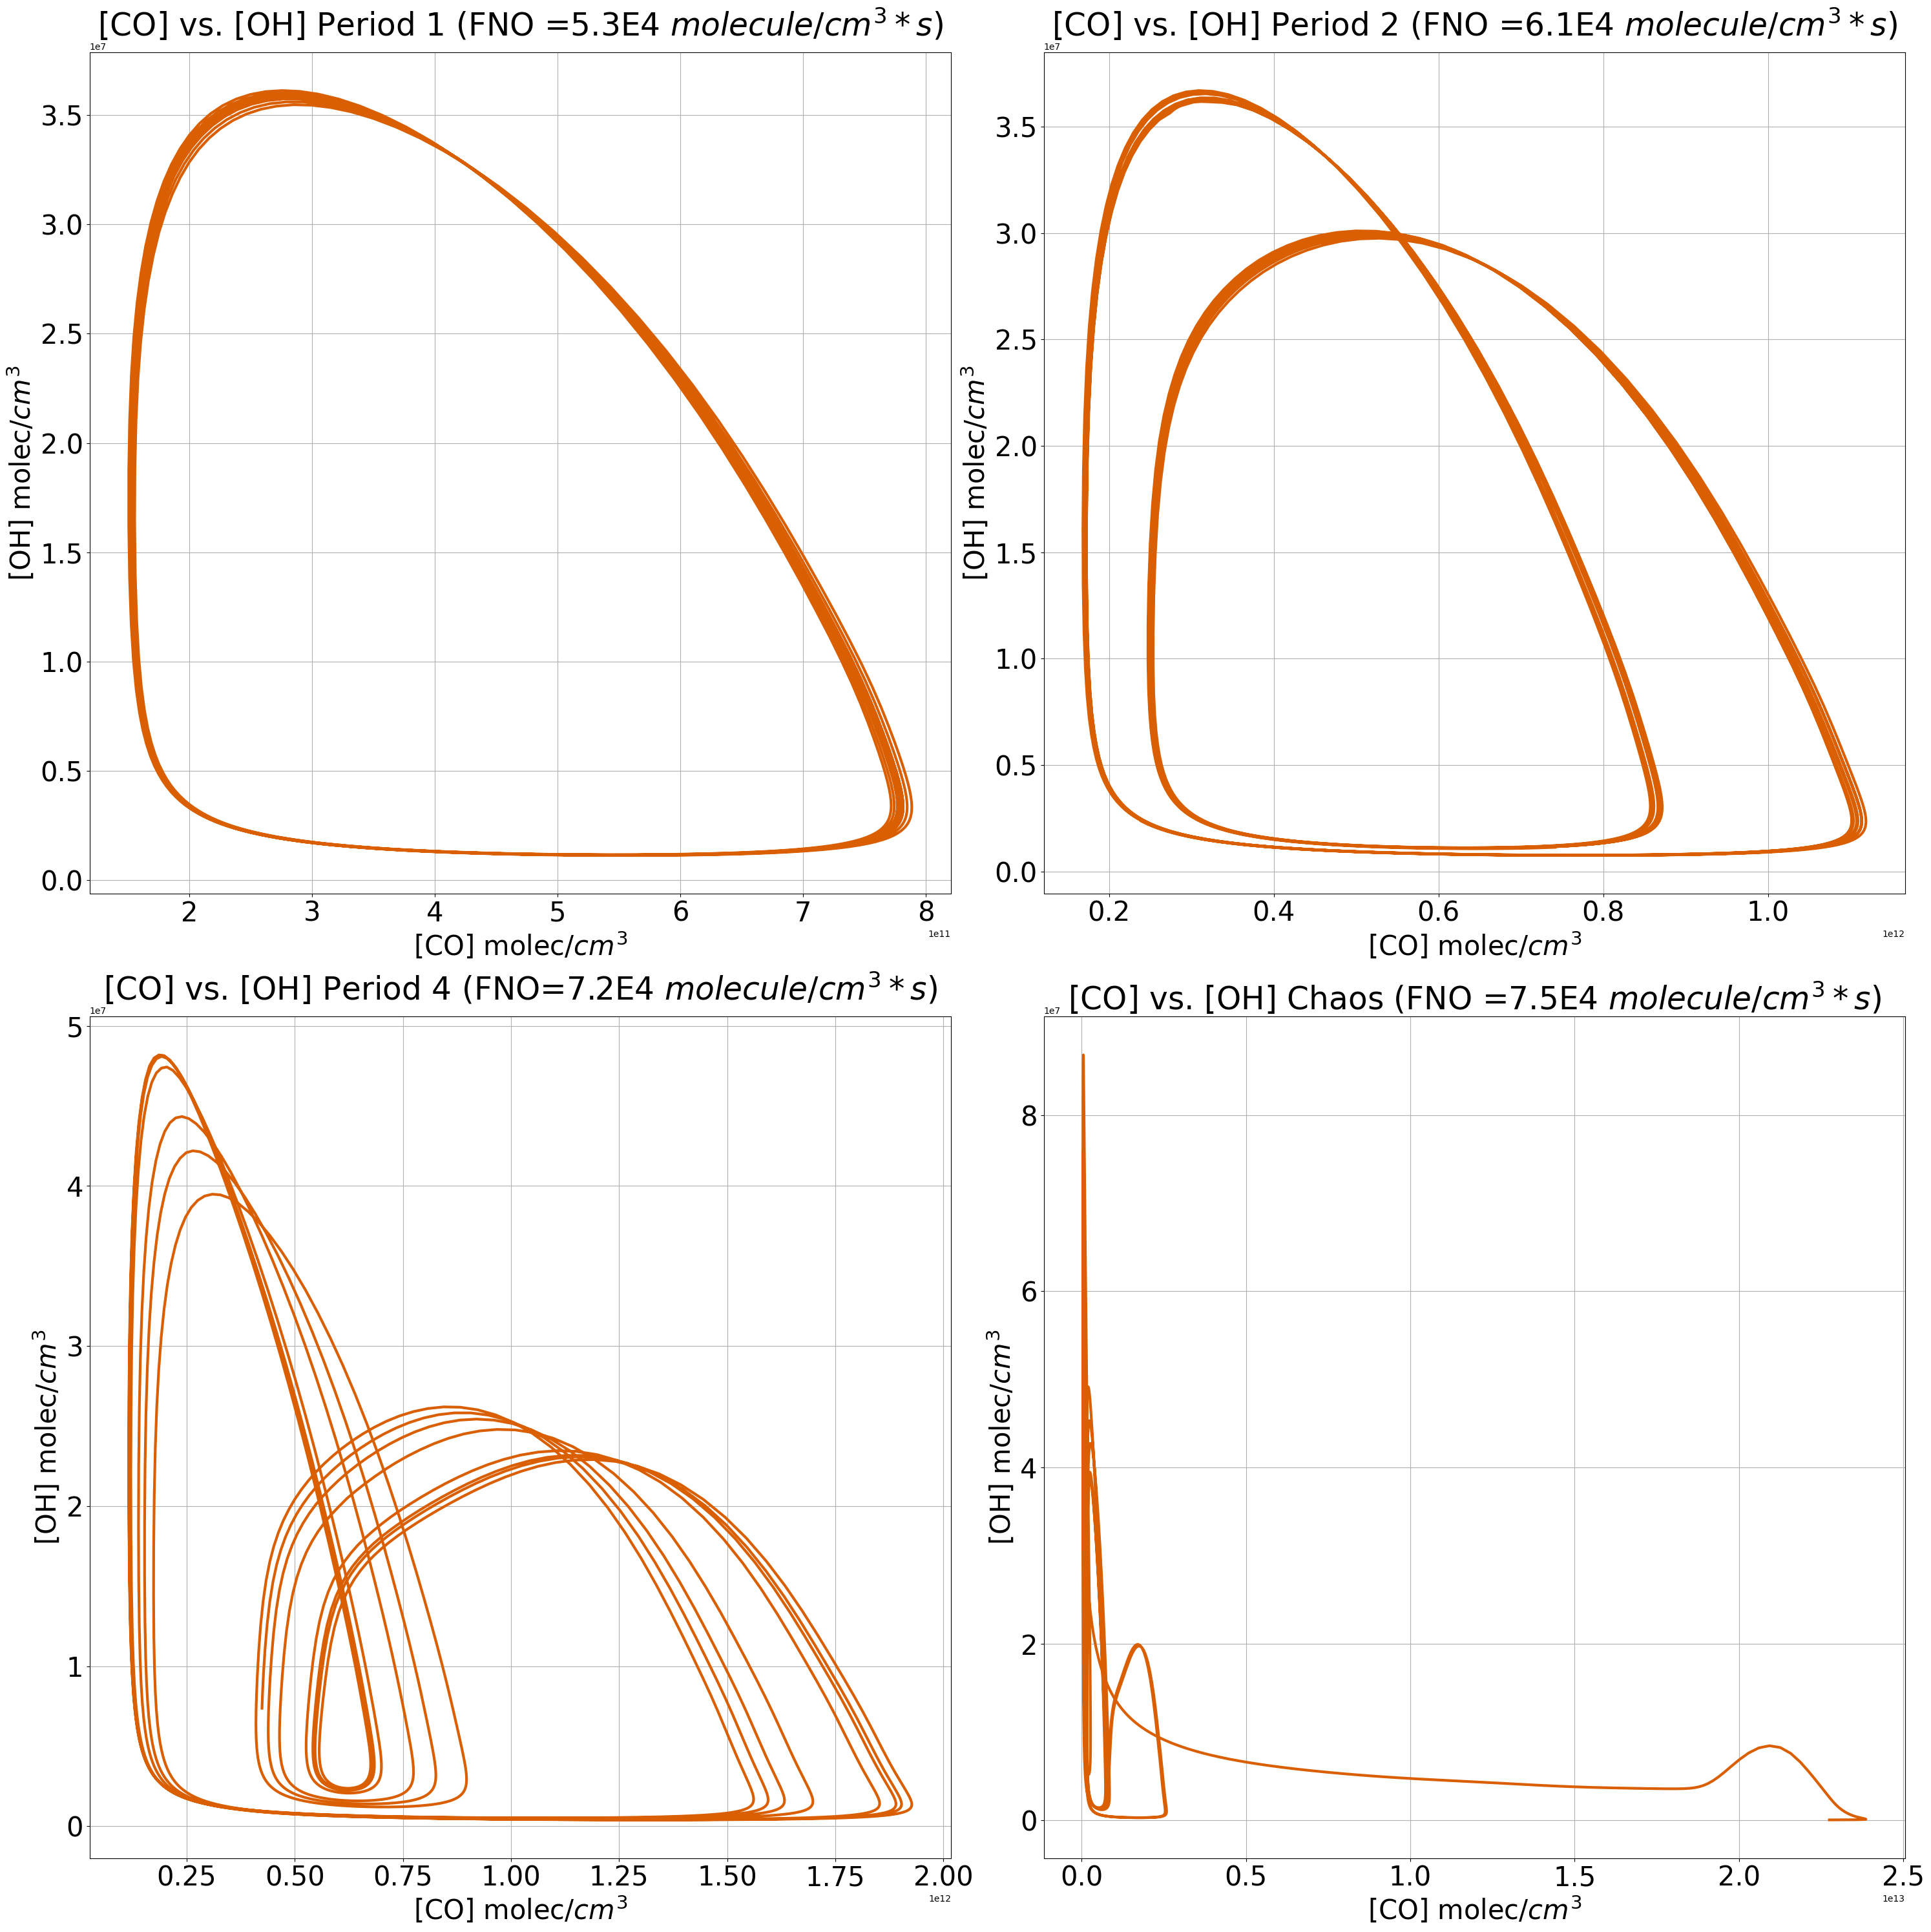

In [10]:
# Phase space for period doubling plotting

fig, axs = plt.subplots(2, 2, figsize=(30, 30))

# Plotting
plots(axs, 0, 0, period1_CO[beg_idx:], period1_OH[beg_idx:], 'CO', 'OH',
      [], [], '[CO] vs. [OH] Period 1 (FNO =5.3E4 $molecule/cm^3*s$)')
plots(axs, 0, 1, period2_CO[beg_idx:], period2_OH[beg_idx:], 'CO', 'OH',
      [], [], '[CO] vs. [OH] Period 2 (FNO =6.1E4 $molecule/cm^3*s$)')
plots(axs, 1, 0, period4_CO[beg_idx:], period4_OH[beg_idx:], 'CO', 'OH',
      [], [], '[CO] vs. [OH] Period 4 (FNO=7.2E4 $molecule/cm^3*s$)')
plots(axs, 1, 1, chaos_CO[beg_idx:], chaos_OH[beg_idx:], 'CO', 'OH',
      [], [], '[CO] vs. [OH] Chaos (FNO =7.5E4 $molecule/cm^3*s$)')

for ax in axs.flat:
    ax.tick_params(axis='both', which='major', labelsize=30)

plt.tight_layout()
plt.show()

**3. Period Doubling + Time Plots**

Here, we will observe period doubling vs. time.

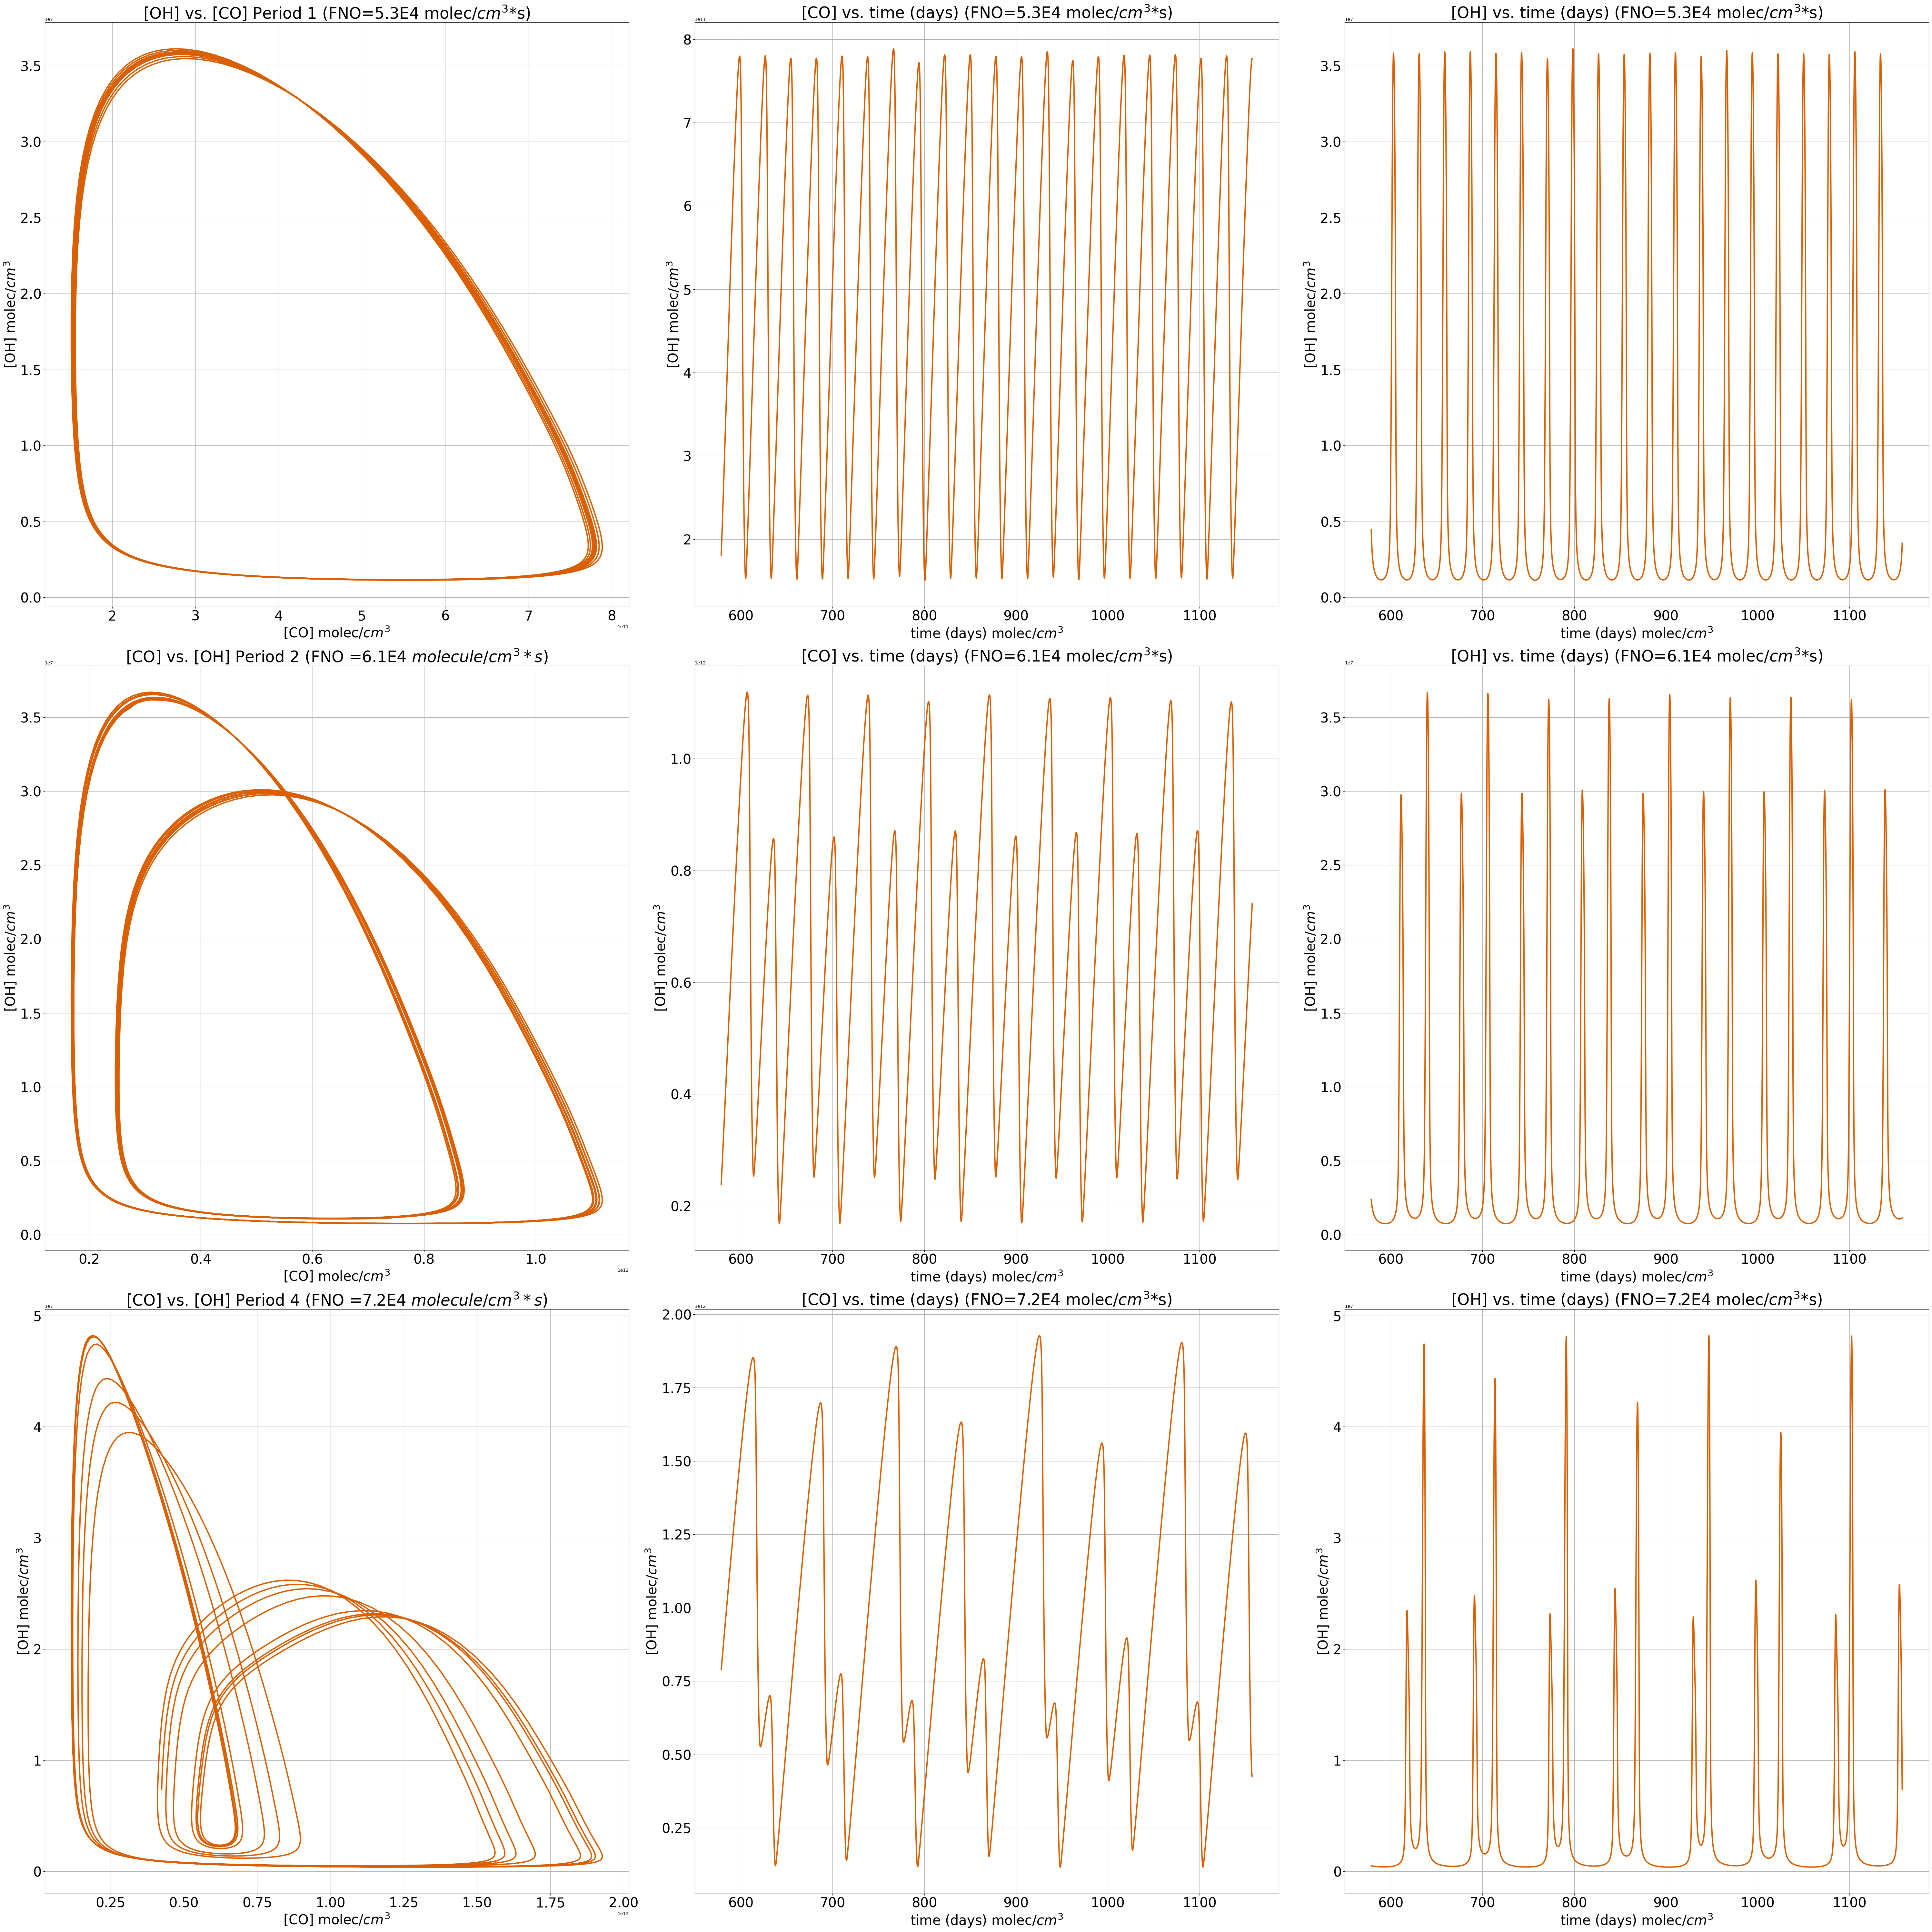

In [11]:
# Plotting
fig, axs = plt.subplots(3, 3, figsize=(60, 60))

# Plotting Phase Space
plots(axs, 0, 0, period1_CO[beg_idx:], period1_OH[beg_idx:], 'CO', 'OH',
      [], [], '[OH] vs. [CO] Period 1 (FNO=5.3E4 molec/$cm^3$*s)')
plots(axs, 1, 0, period2_CO[beg_idx:], period2_OH[beg_idx:], 'CO', 'OH',
      [], [], '[CO] vs. [OH] Period 2 (FNO =6.1E4 $molecule/cm^3*s$)')
plots(axs, 2, 0, period4_CO[beg_idx:], period4_OH[beg_idx:], 'CO', 'OH',
      [], [], '[CO] vs. [OH] Period 4 (FNO =7.2E4 $molecule/cm^3*s$)')

# time vs [CO]
plots(axs, 0, 1, period1_time[beg_idx:], period1_CO[beg_idx:], 'time', 'OH',
      [], [], '[CO] vs. time (days) (FNO=5.3E4 molec/$cm^3$*s)')
plots(axs, 1, 1, period2_time[beg_idx:], period2_CO[beg_idx:], 'time', 'OH',
      [], [], '[CO] vs. time (days) (FNO=6.1E4 molec/$cm^3$*s)')
plots(axs, 2, 1, period4_time[beg_idx:], period4_CO[beg_idx:], 'time', 'OH',
      [], [], '[CO] vs. time (days) (FNO=7.2E4 molec/$cm^3$*s)')

# time vs. [OH]

plots(axs, 0, 2, period1_time[beg_idx:], period1_OH[beg_idx:], 'time', 'OH',
      [], [], '[OH] vs. time (days) (FNO=5.3E4 molec/$cm^3$*s)')
plots(axs, 1, 2, period2_time[beg_idx:], period2_OH[beg_idx:], 'time', 'OH',
      [], [], '[OH] vs. time (days) (FNO=6.1E4 molec/$cm^3$*s)')
plots(axs, 2, 2, period4_time[beg_idx:], period4_OH[beg_idx:], 'time', 'OH',
      [], [], '[OH] vs. time (days) (FNO=7.2E4 molec/$cm^3$*s)')

for ax in axs.flat:
    ax.tick_params(axis='both', which='major', labelsize=30)

plt.tight_layout()
plt.show()

**4. Period Finding**

Now, we are going to calculate the period for each of the FNO values by calculating the distance between the peaks of the [CO] vs. time(days) cycle. In the plots below, the peaks are highlighted. 

We will find that the periods are approximately:

for FNO = 5.3E4 molecules/cm^3*x, ~ 28 days

for FNO = 6.1E4 molecules/cm^3*x, ~ 66 days

for FNO = 7.2E4 molecules/cm^3*x, ~ 155 days


Period for FNO = 5.3E4 molec/$cm^3$*s is approx 27.896308149333436 days
Period for FNO = 6.1E4 molec/$cm^3$*s is approx 65.74731547228794 days
Period for FNO = 7.2E4 molec/$cm^3$*s is approx 155.8026172987669 days


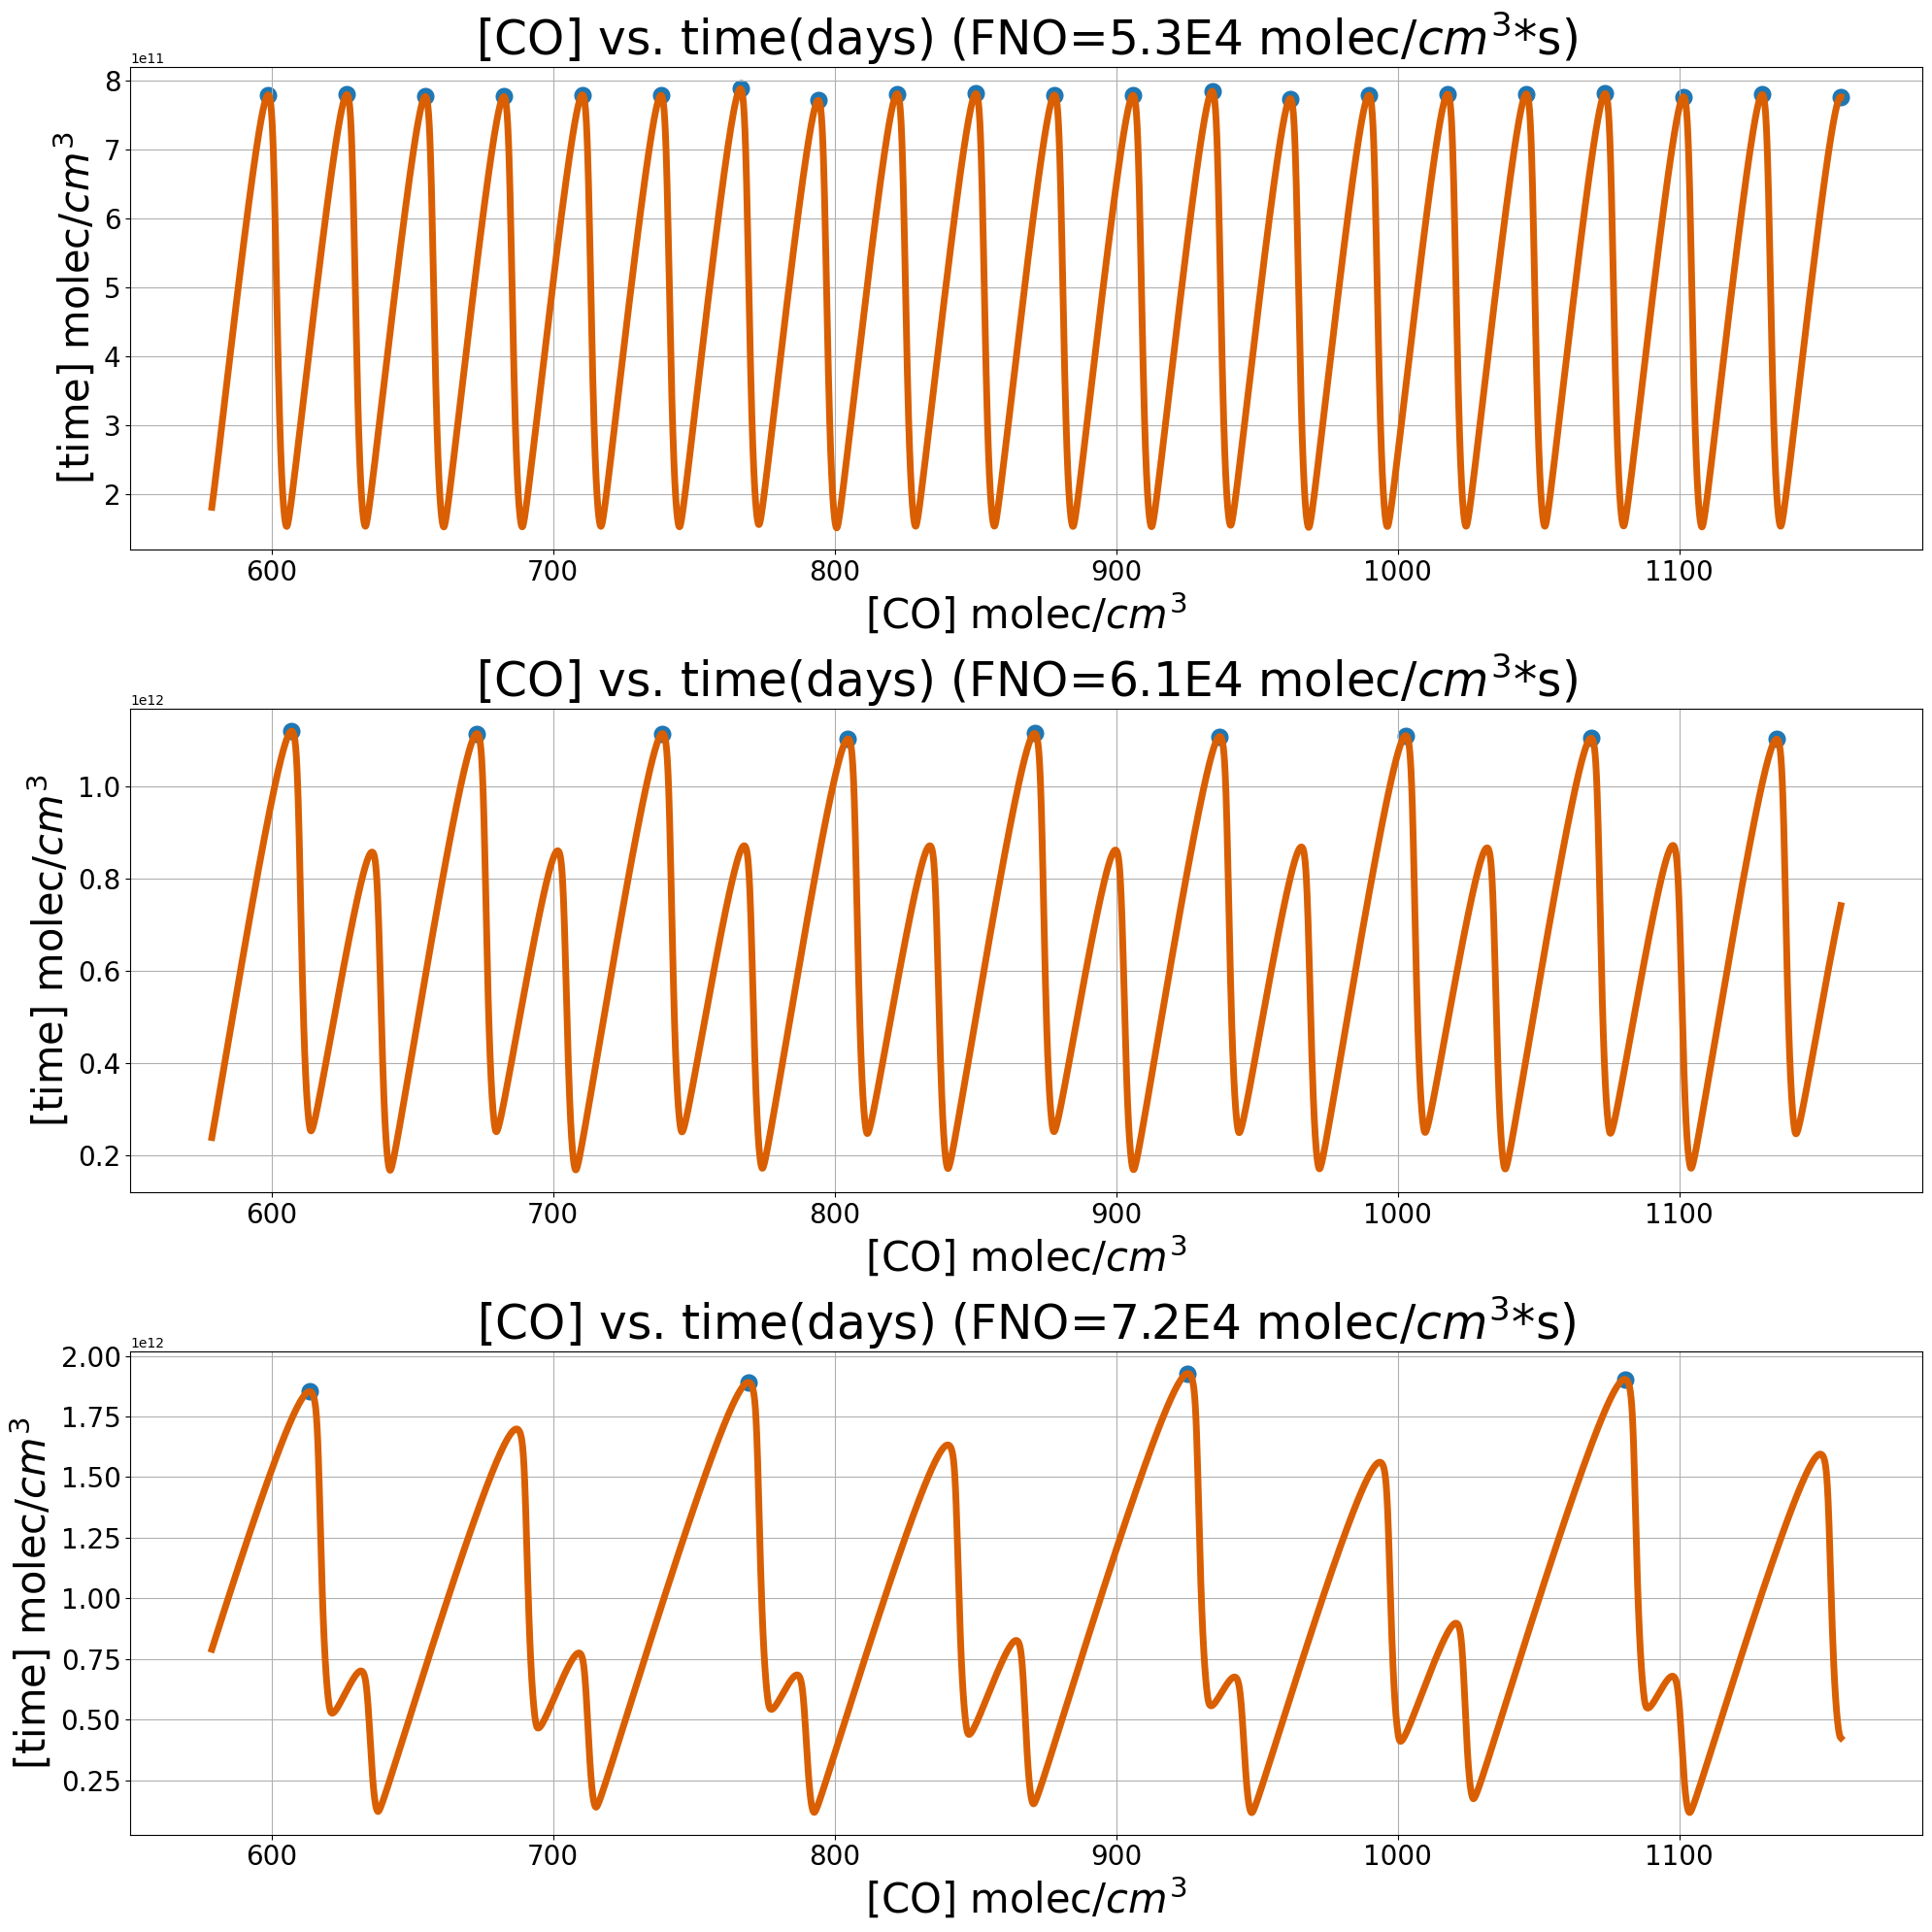

In [12]:
# Setting up plotting
fig, axs = plt.subplots(3, figsize=(20, 20))

# Finding periods and plotting peaks of FNO = 5.3E4
peaks1, _ = find_peaks(period1_CO[beg_idx:])
time = period1_time[peaks1[1]+beg_idx] - period1_time[peaks1[0]+beg_idx]
print("Period for FNO = 5.3E4 molec/$cm^3$*s is approx", time, "days")
plots(axs, 0, -1, period1_time[beg_idx:], period1_CO[beg_idx:], 'CO', 'time',
      period1_time[beg_idx+peaks1], period1_CO[beg_idx+peaks1],
      title="[CO] vs. time(days) (FNO=5.3E4 molec/$cm^3$*s)")

# Finding periods and plotting peaks of FNO = 6.1E4
peaks2, _ = find_peaks(period2_CO[beg_idx:], height=1E12)
time = period2_time[peaks2[1]+beg_idx] - period2_time[peaks2[0]+beg_idx]
print("Period for FNO = 6.1E4 molec/$cm^3$*s is approx", time, "days")
plots(axs, 1, -1, period2_time[beg_idx:], period2_CO[beg_idx:], 'CO', 'time',
      period2_time[beg_idx+peaks2], period2_CO[beg_idx+peaks2],
      title="[CO] vs. time(days) (FNO=6.1E4 molec/$cm^3$*s)")

# Finding periods and plotting peaks of FNO = 7.2E4
peaks4, _ = find_peaks(period4_CO[beg_idx:], height=1.5E12, distance=1000)
time = period4_time[peaks4[1]+beg_idx]-period4_time[peaks4[0]+beg_idx]
print("Period for FNO = 7.2E4 molec/$cm^3$*s is approx", time, "days")
plots(axs, 2, -1, period4_time[beg_idx:], period4_CO[beg_idx:], 'CO', 'time',
      period4_time[beg_idx+peaks4], period4_CO[beg_idx+peaks4],
      title="[CO] vs. time(days) (FNO=7.2E4 molec/$cm^3$*s)")

for ax in axs.flat:
    ax.tick_params(axis='both', which='major', labelsize=20)

plt.tight_layout()
plt.show()

# Period Doubling and Period Halving Bifurcation plots 

The phenomena of period doubling can lead to the formation of bifurcation diagrams. 
As a system’s period continues to double (period doubling cascade), the system becomes more chaotic (similar to how we saw the system become more chaotic for FNO = 7.5E4 molecules/cm^3 *s).
However, if a system’s period instead halves (period halving bifurcation), the system becomes more uniform. 


1. Period Doubling Bifurcations: The first bifurcation plot below is made while changing the parameter: FNO (emissions of NO). 
This bifurcation plot demonstrates how the composition of the atmosphere is very sensitive to the forcing (emissions) of NO. 
In our bifurcation diagrams, we see changing the amount of NO can not only predict ozone (or another variable), but also change the predictability of the system. 
As the forcing of NO increases, there is more chaos, so it becomes more difficult to predict which state the system will be in. 
This also demonstrates the nonlinearity in the underlying dynamics of our troposphere’s chemical composition. 

2. Period Halving Bifurcations: The second bifurcation plot is made while changing FO3 (emissions of O3). 
Again, we see that the composition of the atmosphere is very sensitive to the emissions of O3. 
The emissions of O3 can change the predictability of our system. 
However, unlike the period doubling bifurcation, the system becomes more stable with higher forcings of O3. 



The system demonstrated in these bifurcation diagrams only describes small subsystems within the troposphere. 
So, in creating more complete models, this chemical model is coupled with a meteorological model, which is chaotic in itself. 
Thus, predicting atmospheric behavior and concentrations has extremely chaotic behavior. 

**1.Period Doubling**

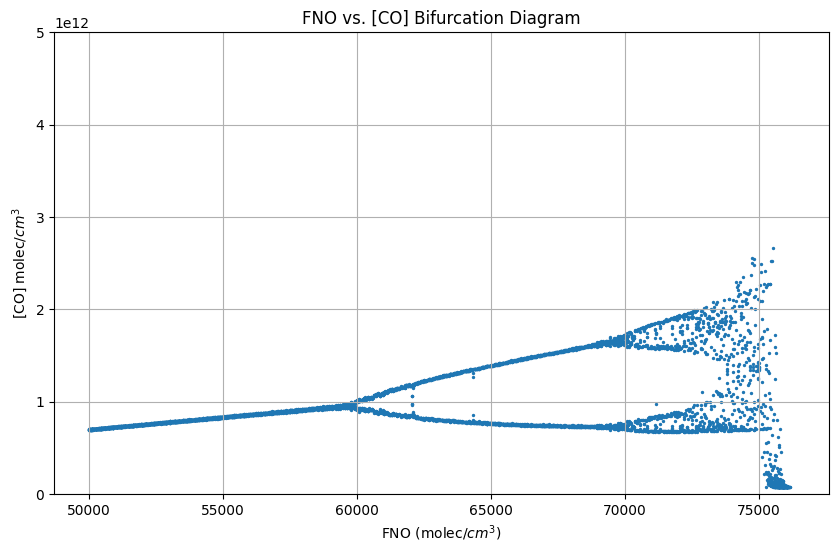

In [13]:
# Bifurcation Plots - for a FNO vs. [CO] Bifurcation Plot

# Setting up time for integration
time_steps = 10000
t = np.linspace(t0, tf, time_steps)

# getting a range of FNO values, bounds from Field et. al
num_FNO = 1000
vals_FNO = np.linspace(5.0E4, 8E4, num_FNO)

# intial conditions
X0 = 5E11, 5E9, 3E11, 5E9, 5E6, 2.5E8

# setting up arrays for plotting
maxima_FNO = []
maxima_CO = []

# spin up arbitrarily chosen
spin_up = .8

# loops through all sampled FNO values
for FNO in vals_FNO:
    # integration
    X = solve_ivp(dXdt, (t0, tf), X0, t_eval=t, method='LSODA')

    CO, _, _, _, _, _ = X.y

    # only all local maxima of the limit cycles because
    # maxima generally represent stable states
    # collaborated with Prof Kavassalis
    index = round(time_steps*spin_up)
    steady_state_CO = CO[index:]
    local_maxima = argrelextrema(steady_state_CO, np.greater)

    # record each local maxima for corresponding FNO value
    for maximum in steady_state_CO[local_maxima]:
        maxima_FNO.append(FNO)
        maxima_CO.append(maximum)


# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(maxima_FNO, maxima_CO, s=2)
plt.grid()
plt.xlabel('FNO (molec/$cm^3$)')
plt.ylabel('[CO] molec/$cm^3$')
plt.ylim(0, .5E13)
plt.title('FNO vs. [CO] Bifurcation Diagram')
plt.show()

**2.Period Halving**

In [15]:
# Period Halving Plots for FO3 vs. [CO]

# time steps for integration
time_steps = 10000
t = np.linspace(t0, tf, time_steps)

# getting a range of FO3 values
FNO = 6.3E4
num_FO3 = 1000
vals_FO3 = np.linspace(5.0E4, 8E4, num_FO3)

# setting up arrays for plotting
maxima_FO3 = []
maxima_CO = []

# spin up arbitrarily chosen
spin_up = .8

# loops through all sampled FO3 values
for FO3 in vals_FO3:
    # initial conditions
    X0 = 5E11, 5E9, 3E11, 5E9, 5E6, 2.5E8

    # integration
    X = solve_ivp(dXdt, (t0, tf), X0, t_eval=t, method='LSODA')

    CO, _, _, _, _, _ = X.y

    # only take max values of limit cycles for stable states
    # collaborated with Prof Kavassalis
    index = round(time_steps*spin_up)
    steady_state_CO = CO[index:]
    local_maxima = argrelextrema(steady_state_CO, np.greater)

    # we record each local maxima for corresponding FNO value
    for maximum in steady_state_CO[local_maxima]:
        maxima_FO3.append(FO3)
        maxima_CO.append(maximum)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(maxima_FO3, maxima_CO, s=2)
plt.grid()
plt.xlabel('FO3 molec/$cm^3$ * s')
plt.ylabel('[CO] molec/$cm^3$')
plt.ylim(0, 2E12)
plt.title('FO3 vs. [CO] Period Halving Bifurcation')
plt.show()